In [268]:
import torch


class BalancedDataLoaderIterator:
    '''
    This class iterates over multiple PyTorch dataloaders in a balanced way, 
    ensuring that all dataloaders contribute to the training equally. 
    It uses random sampling to choose from multiple dataloaders while 
    handling different dataset lengths.
    '''
    def __init__(self, dataloaders):
        self.dataloaders = dataloaders

        self.num_dataloaders = len(dataloaders)

        max_length = max(len(dataloader) for dataloader in dataloaders)

        length_list = [len(dataloader) for dataloader in dataloaders]
        print("data loader length:", length_list)
        print("max dataloader length:", max_length,
              "epoch iteration:", max_length * self.num_dataloaders)
        self.total_length = max_length * self.num_dataloaders
        self.current_iteration = 0
        self.probabilities = torch.ones(
            self.num_dataloaders, dtype=torch.float) / self.num_dataloaders

    def __iter__(self):
        self.iterators = [iter(dataloader) for dataloader in self.dataloaders]
        self.current_iteration = 0
        return self

    def __next__(self):
        if self.current_iteration >= self.total_length:
            raise StopIteration

        chosen_index = torch.multinomial(self.probabilities, 1).item()
        try:
            sample = next(self.iterators[chosen_index])
        except StopIteration:
            self.iterators[chosen_index] = iter(self.dataloaders[chosen_index])
            sample = next(self.iterators[chosen_index])

        self.current_iteration += 1
        return sample, chosen_index

    def __len__(self):
        return self.total_length

In [ ]:
# load crypto
import pandas as pd
import numpy as np

crypto = pd.read_csv('crypto.csv')

In [24]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import dateutil.parser
import matplotlib.pyplot as plt

# --------------------------- #
#        Data Preprocessing   #
# --------------------------- #
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import dateutil.parser

def load_all_sites_balanced(
    base_dir='../processed_ds/air_quality_cluster/', 
    window_size=32, 
    horizon=16, 
    batch_size=16,
    min_date=None, 
    max_date=None
):
    """
    Loads and preprocesses time series data for all sites, ensuring balanced training across sites.

    Args:
    - base_dir (str): Path to the directory containing site folders.
    - window_size (int): Number of past time steps for input.
    - horizon (int): Number of future steps to predict.
    - batch_size (int): Batch size for DataLoader.
    - min_date (str or datetime, optional): Start date for filtering data.
    - max_date (str or datetime, optional): End date for filtering data.

    Returns:
    - balanced_train_loader: Balanced DataLoader across all sites for training.
    - site_val_loaders: Dictionary of validation DataLoaders per site.
    - site_test_loaders: Dictionary of test DataLoaders per site.
    """
    
    # Get the list of site directories
    site_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    site_dirs.sort()

    train_loaders = []
    site_val_loaders = {}
    site_test_loaders = {}

    for site in site_dirs:
        site_path = os.path.join(base_dir, site)
        csv_files = [f for f in os.listdir(site_path) if f.endswith('.csv')]
        csv_files.sort()

        for csv_file in csv_files:
            file_path = os.path.join(site_path, csv_file)
            df_site = pd.read_csv(file_path)

            # Convert date column to datetime if it exists
            if 'date' in df_site.columns:
                df_site['date'] = pd.to_datetime(df_site['date'])

                # Filter based on min_date and max_date
                if min_date:
                    min_date = dateutil.parser.parse(min_date) if isinstance(min_date, str) else min_date
                    df_site = df_site[df_site['date'] >= min_date]

                if max_date:
                    max_date = dateutil.parser.parse(max_date) if isinstance(max_date, str) else max_date
                    df_site = df_site[df_site['date'] <= max_date]

                # Drop date column after filtering
                df_site.drop(columns=['date'], inplace=True)

            # Perform 80-20 train-test split
            train_size = int(0.8 * len(df_site))
            train_df = df_site.iloc[:train_size]
            test_df = df_site.iloc[train_size:]

            # Split train_df further into Train (80%) and Validation (20%)
            val_size = int(0.2 * len(train_df))  # 16% of full dataset
            train_df, val_df = train_df.iloc[:-val_size], train_df.iloc[-val_size:]

            print(f"Site: {site} | Train: {len(train_df)} | Validation: {len(val_df)} | Test: {len(test_df)}")

            # Standardize data per site (avoid data leakage)
            train_mean, train_std = train_df.mean(), train_df.std()
            train_df = (train_df - train_mean) / (train_std + 1e-8)
            val_df = (val_df - train_mean) / (train_std + 1e-8)
            test_df = (test_df - train_mean) / (train_std + 1e-8)

            # Convert DataFrame to NumPy arrays for LSTM
            X_train, y_train = df_to_X_y(train_df, window_size, horizon)
            X_val, y_val = df_to_X_y(val_df, window_size, horizon)
            X_test, y_test = df_to_X_y(test_df, window_size, horizon)

            # Convert to PyTorch tensors
            train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
            val_data = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
            test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

            # Create DataLoaders
            train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
            val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size, drop_last=True)
            test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

            # Store loaders for this site
            train_loaders.append(train_loader)
            site_val_loaders[site] = val_loader
            site_test_loaders[site] = test_loader

    # Create Balanced DataLoader for Training
    balanced_train_loader = BalancedDataLoaderIterator(train_loaders)

    return balanced_train_loader, site_val_loaders, site_test_loaders

def load_all_sites_data(
    base_dir='../processed_ds/air_quality_cluster/', 
    window_size=32, 
    horizon=16, 
    batch_size=16,
    min_date=None, 
    max_date=None
):
    """
    Loads and preprocesses time series data for all sites in a directory.

    Args:
    - base_dir (str): Path to the directory containing site folders.
    - window_size (int): Number of past time steps for input.
    - horizon (int): Number of future steps to predict.
    - batch_size (int): Batch size for DataLoader.
    - min_date (str or datetime, optional): Start date for filtering data.
    - max_date (str or datetime, optional): End date for filtering data.

    Returns:
    - train_loader, val_loader, test_loader: DataLoaders for training, validation, and testing.
    """
    
    # Get the list of site directories
    site_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    site_dirs.sort()

    train_dfs, val_dfs, test_dfs = [], [], []

    for site in site_dirs:
        site_path = os.path.join(base_dir, site)
        csv_files = [f for f in os.listdir(site_path) if f.endswith('.csv')]
        csv_files.sort()

        for csv_file in csv_files:
            file_path = os.path.join(site_path, csv_file)
            df_site = pd.read_csv(file_path)

            # Convert date column to datetime if it exists
            if 'date' in df_site.columns:
                df_site['date'] = pd.to_datetime(df_site['date'])

                # Filter based on min_date and max_date
                if min_date:
                    min_date = dateutil.parser.parse(min_date) if isinstance(min_date, str) else min_date
                    df_site = df_site[df_site['date'] >= min_date]

                if max_date:
                    max_date = dateutil.parser.parse(max_date) if isinstance(max_date, str) else max_date
                    df_site = df_site[df_site['date'] <= max_date]

                # Drop date column after filtering
                df_site.drop(columns=['date'], inplace=True)

            # # Add a site identifier column
            # df_site['site'] = int(site.split('-')[1])

            # Perform 80-20 train-test split
            train_size = int(0.8 * len(df_site))
            train_df = df_site.iloc[:train_size]
            test_df = df_site.iloc[train_size:]

            # Split train_df further into Train (80%) and Validation (20%)
            val_size = int(0.2 * len(train_df))  # 16% of full dataset
            train_df, val_df = train_df.iloc[:-val_size], train_df.iloc[-val_size:]

            # Store separate train, val, and test sets
            train_dfs.append(train_df)
            val_dfs.append(val_df)
            test_dfs.append(test_df)

    # Concatenate all site data for train, validation, and test
    train_df = pd.concat(train_dfs, ignore_index=True)
    val_df = pd.concat(val_dfs, ignore_index=True)
    test_df = pd.concat(test_dfs, ignore_index=True)

    # Concat traindf, val_df and test_df and save as pdf

    print(f"Total Train Size: {len(train_df)} | Validation Size: {len(val_df)} | Test Size: {len(test_df)}")

    # Standardize the data using only train statistics
    train_mean, train_std = train_df.mean(), train_df.std()
    train_df = (train_df - train_mean) / (train_std + 1e-8)
    val_df = (val_df - train_mean) / (train_std + 1e-8)  # Normalize validation using train stats
    test_df = (test_df - train_mean) / (train_std + 1e-8)  # Normalize test using train stats

    # Convert DataFrame to NumPy arrays for LSTM
    X_train, y_train = df_to_X_y(train_df, window_size, horizon)
    X_val, y_val = df_to_X_y(val_df, window_size, horizon)
    X_test, y_test = df_to_X_y(test_df, window_size, horizon)

    # Convert to PyTorch tensors
    train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    val_data = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
    test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

    # Create DataLoaders
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

    return train_loader, val_loader, test_loader


def load_all_sites_data_independent_tests(
    base_dir='../processed_ds/air_quality_cluster/', 
    window_size=32, 
    horizon=16, 
    batch_size=16,
    min_date=None, 
    max_date=None
):
    """
    Loads and preprocesses time series data for all sites in a directory.
    Ensures that test sets are NOT concatenated (kept independent per site).

    Args:
    - base_dir (str): Path to the directory containing site folders.
    - window_size (int): Number of past time steps for input.
    - horizon (int): Number of future steps to predict.
    - batch_size (int): Batch size for DataLoader.
    - min_date (str or datetime, optional): Start date for filtering data.
    - max_date (str or datetime, optional): End date for filtering data.

    Returns:
    - train_loader (DataLoader): DataLoader for training.
    - val_loader (DataLoader): DataLoader for validation.
    - test_loaders (dict): Dictionary of DataLoaders for testing per site.
    """
    
    import dateutil.parser
    
    # Get the list of site directories
    site_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    site_dirs.sort()

    train_dfs, val_dfs = [], []
    test_loaders = {}  # Dictionary to store independent test loaders for each site

    for site in site_dirs:
        site_path = os.path.join(base_dir, site)
        csv_files = [f for f in os.listdir(site_path) if f.endswith('.csv')]
        csv_files.sort()

        for csv_file in csv_files:
            file_path = os.path.join(site_path, csv_file)
            df_site = pd.read_csv(file_path)

            # Convert date column to datetime if it exists
            if 'date' in df_site.columns:
                df_site['date'] = pd.to_datetime(df_site['date'])

                # Filter based on min_date and max_date
                if min_date:
                    min_date = dateutil.parser.parse(min_date) if isinstance(min_date, str) else min_date
                    df_site = df_site[df_site['date'] >= min_date]

                if max_date:
                    max_date = dateutil.parser.parse(max_date) if isinstance(max_date, str) else max_date
                    df_site = df_site[df_site['date'] <= max_date]

                # Drop date column after filtering
                df_site.drop(columns=['date'], inplace=True)

            # Perform 80-20 train-test split
            train_size = int(0.8 * len(df_site))
            train_df = df_site.iloc[:train_size]
            test_df = df_site.iloc[train_size:]

            # Split train_df further into Train (80%) and Validation (20%)
            val_size = int(0.2 * len(train_df))  # 16% of full dataset
            train_df, val_df = train_df.iloc[:-val_size], train_df.iloc[-val_size:]

            # Store separate train and validation sets
            train_dfs.append(train_df)
            val_dfs.append(val_df)

            # Standardize test_df using training statistics
            train_mean, train_std = train_df.mean(), train_df.std()
            test_df = (test_df - train_mean) / (train_std + 1e-8)  # Normalize test using train stats

            # Convert test set to tensors
            X_test, y_test = df_to_X_y(test_df, window_size, horizon)
            test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
            test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

            # Store test_loader in dictionary with site name
            test_loaders[site] = test_loader

    # Concatenate all site data for train and validation
    train_df = pd.concat(train_dfs, ignore_index=True)
    val_df = pd.concat(val_dfs, ignore_index=True)

    print(f"Total Train Size: {len(train_df)} | Validation Size: {len(val_df)} | Test Sites: {len(test_loaders)}")

    # Standardize the training and validation data using only train statistics
    train_mean, train_std = train_df.mean(), train_df.std()
    train_df = (train_df - train_mean) / (train_std + 1e-8)
    val_df = (val_df - train_mean) / (train_std + 1e-8)  # Normalize validation using train stats

    # Convert DataFrame to NumPy arrays for LSTM
    X_train, y_train = df_to_X_y(train_df, window_size, horizon)
    X_val, y_val = df_to_X_y(val_df, window_size, horizon)

    # Convert to PyTorch tensors
    train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    val_data = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())

    # Create DataLoaders
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size, drop_last=True)

    return train_loader, val_loader, test_loaders



import os
import pandas as pd
import dateutil.parser

# --------------------------- #
#        Population Data Loader for Units  #
# --------------------------- #
def load_all_sites_data_UniTs(
    base_dir='../processed_ds/air_quality_cluster/', 
    output_file='processed_air_quality.csv',
    min_date=None, 
    max_date=None
):
    """
    Loads and preprocesses time series data for all sites,
    splitting each site's data into train, validation, and test sets
    before concatenating them. This ensures that the test set contains
    data from all sites.
    """
    
    # Get list of site directories
    site_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    site_dirs.sort()
    
    train_dfs, val_dfs, test_dfs = [], [], []

    for site in site_dirs:
        site_path = os.path.join(base_dir, site)
        csv_files = [f for f in os.listdir(site_path) if f.endswith('.csv')]
        csv_files.sort()

        for csv_file in csv_files:
            file_path = os.path.join(site_path, csv_file)
            df_site = pd.read_csv(file_path)

            # Convert 'date' column if it exists and filter by date range
            if 'date' in df_site.columns:
                df_site['date'] = pd.to_datetime(df_site['date'])
                if min_date:
                    min_date_val = dateutil.parser.parse(min_date) if isinstance(min_date, str) else min_date
                    df_site = df_site[df_site['date'] >= min_date_val]
                if max_date:
                    max_date_val = dateutil.parser.parse(max_date) if isinstance(max_date, str) else max_date
                    df_site = df_site[df_site['date'] <= max_date_val]
                # Sort by date to maintain time order
                df_site.sort_values(by='date', inplace=True)
                df_site.reset_index(drop=True, inplace=True)

            # Perform a time-based split for this site's data
            num_points = len(df_site)
            if num_points == 0:
                continue  # Skip if no data after filtering

            # Define split sizes (e.g., 70% train, 10% validation, 20% test)
            num_train = int(num_points * 0.7)
            num_test = int(num_points * 0.2)
            num_val = num_points - num_train - num_test  # Remaining for validation

            # Ensure that each split is non-empty
            if num_train < 1 or num_val < 1 or num_test < 1:
                continue

            train_df = df_site.iloc[:num_train]
            val_df = df_site.iloc[num_train:num_train+num_val]
            test_df = df_site.iloc[num_train+num_val:]

            train_dfs.append(train_df)
            val_dfs.append(val_df)
            test_dfs.append(test_df)

    # Concatenate all sites' splits
    train_df = pd.concat(train_dfs, ignore_index=True)
    val_df = pd.concat(val_dfs, ignore_index=True)
    test_df = pd.concat(test_dfs, ignore_index=True)

    # (Optional) Save the concatenated DataFrame if needed:
    df_all = pd.concat([train_df, val_df, test_df], ignore_index=True)
    df_all.to_csv(output_file, index=False)
    
    return train_df, val_df, test_df

def load_and_save_all_sites_data(
    base_dir='../processed_ds/air_quality_cluster/',
    output_file='processed_air_quality.csv',
    min_date=None,
    max_date=None
):
    """
    Loads and preprocesses time series data for all sites in a directory and saves it as a CSV.

    Args:
    - base_dir (str): Path to the directory containing site folders.
    - output_file (str): Path to save the processed dataset.
    - min_date (str or datetime, optional): Start date for filtering data.
    - max_date (str or datetime, optional): End date for filtering data.

    Returns:
    - None (Saves the concatenated dataset to `output_file`).
    """
    
    # Get the list of site directories
    site_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    site_dirs.sort()

    all_dfs = []

    for site in site_dirs:
        site_path = os.path.join(base_dir, site)
        csv_files = [f for f in os.listdir(site_path) if f.endswith('.csv')]
        csv_files.sort()

        for csv_file in csv_files:
            file_path = os.path.join(site_path, csv_file)
            df_site = pd.read_csv(file_path)

            # Convert date column to datetime if it exists
            if 'date' in df_site.columns:
                df_site['date'] = pd.to_datetime(df_site['date'])

                # Filter based on min_date and max_date
                if min_date:
                    min_date = dateutil.parser.parse(min_date) if isinstance(min_date, str) else min_date
                    df_site = df_site[df_site['date'] >= min_date]

                if max_date:
                    max_date = dateutil.parser.parse(max_date) if isinstance(max_date, str) else max_date
                    df_site = df_site[df_site['date'] <= max_date]

            # drop date column after filtering
            # df_site.drop(columns=['date'], inplace=True)

            # Append to list
            all_dfs.append(df_site)

    # # Concatenate all site data
    final_df = pd.concat(all_dfs, ignore_index=True)

    # print(f"Total Samples: {len(final_df)}")

    # # Standardize the data using only train statistics
    final_mean, final_std = final_df.mean(), final_df.std()
    final_df = (final_df - final_mean) / (final_std + 1e-8)

    # Save the processed dataset  d
    final_df.to_csv(output_file, index=False)
    print(f"Processed dataset saved to: {output_file}")


def load_and_preprocess_site_data(site_path, window_size=32, horizon=16, min_date=None, max_date=None, batch_size=16):
    """
    Loads and preprocesses time series data for a given site.

    Args:
    - site_path (str): Path to the site CSV file.
    - window_size (int): Number of past time steps for input.
    - horizon (int): Number of future steps to predict.

    Returns:
    - train_loader, val_loader, test_loader: DataLoaders for training, validation, and testing.
    """
    df = pd.read_csv(site_path)
    
    # Convert date column to datetime if it exists
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])

        # Filter data between min_date and max_date
        if min_date:
            min_date = dateutil.parser.parse(min_date) if isinstance(min_date, str) else min_date
            df = df[df['date'] >= min_date]

        if max_date:
            max_date = dateutil.parser.parse(max_date) if isinstance(max_date, str) else max_date
            df = df[df['date'] <= max_date]

        # Drop the date column after filtering
        df.drop(columns=['date'], inplace=True)
        
    
    # Perform an 80-20 split based on time order
    train_size = int(0.8 * len(df))
    train_df = df.iloc[:train_size]  # 80% for training & validation
    test_df = df.iloc[train_size:]   # 20% for final testing (future unseen data)

    # Split train_df further into Train (80%) and Validation (20%)
    val_size = int(0.2 * len(train_df))  # 16% of full dataset
    train_df, val_df = train_df.iloc[:-val_size], train_df.iloc[-val_size:]

    print(f"Train size: {len(train_df)} | Validation size: {len(val_df)} | Test size: {len(test_df)}")

    # Standardize each separately to prevent data leakage
    train_mean, train_std = train_df.mean(), train_df.std()
    
    train_df = (train_df - train_mean) / (train_std + 1e-8)
    val_df = (val_df - train_mean) / (train_std + 1e-8)  # Normalize validation using train stats
    test_df = (test_df - train_mean) / (train_std + 1e-8)  # Normalize test using train stats

    # Convert DataFrame to NumPy arrays for LSTM
    X_train, y_train = df_to_X_y(train_df,window_size, horizon)
    X_val, y_val = df_to_X_y(val_df, window_size, horizon)
    X_test, y_test = df_to_X_y(test_df, window_size, horizon)

    # Convert to PyTorch tensors
    train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    val_data = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
    test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

    # Create DataLoaders
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

    return train_loader, val_loader, test_loader


def df_to_X_y(df, window_size=32, horizon=16):
    """
    Converts a DataFrame into supervised learning format for LSTM.

    Args:
    - df (pd.DataFrame): DataFrame containing time series.
    - window_size (int): Past window size.
    - horizon (int): Number of future steps.

    Returns:
    - X (np.array): Features.
    - y (np.array): Targets.
    """
    if "OT" not in df.columns:
        raise ValueError("The target column 'OT' is missing from the DataFrame.")

    df_as_np = df.to_numpy()
    target_col_idx = df.columns.get_loc("OT")  # Get the index of 'OT' column

    X, y = [], []

    for i in range(len(df_as_np) - window_size - horizon + 1):
        X.append(df_as_np[i:i + window_size])  # Past 'window_size' rows as features
        y.append(df_as_np[i + window_size:i + window_size + horizon, target_col_idx])  # Next 'horizon' steps for target

    return np.array(X), np.array(y)



# --------------------------- #
#          LSTM Model         #
# --------------------------- #

class LSTMModel(nn.Module):
    def __init__(self, num_features, time_window, output_window, num_labels, num_layers=2, hidden_size=16, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.output_window = output_window
        self.num_labels = num_labels

        self.lstm = nn.LSTM(num_features,
                            hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, num_labels * output_window)

    def forward(self, x):
        B, T, D = x.shape  
        x_, _ = self.lstm(x)
        last_hidden = x_[:, -1, :]  # Take last time step's hidden state
        x_ = self.fc(last_hidden)
        x_ = x_.reshape(B, self.output_window, self.num_labels)
        return x_


# --------------------------- #
#      Training Function      #
# --------------------------- #

def train_model(model, train_loader, val_loader, num_epochs=30, lr=1e-3, wd=1e-5):
    """
    Trains an LSTM model with validation.

    Args:
    - model (nn.Module): The LSTM model.
    - train_loader (DataLoader): DataLoader for training.
    - val_loader (DataLoader): DataLoader for validation.
    - num_epochs (int): Number of training epochs.
    - lr (float): Learning rate.

    Returns:
    - None
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=wd)
    device = "cuda"

    model.to(device)
    
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # print(f"\nEPOCH {epoch+1}")
        
        # -------------------- Training -------------------- #
        model.train()
        running_train_loss = 0.0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            output = model(batch_x)
            loss = criterion(output, batch_y.unsqueeze(-1))  # Ensure correct shape
            running_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = running_train_loss / len(train_loader)
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # -------------------- Validation -------------------- #
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():  # Disable gradient calculations
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                output = model(batch_x)
                loss = criterion(output, batch_y.unsqueeze(-1))  # Ensure correct shape
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)


        # Print losses for the epoch
        print(f"Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")

    print("Training complete!")
     # -------------------- Plot Loss Curves -------------------- #

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='s')
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_losses, val_losses



# --------------------------- #
#      Evaluation Function    #
# --------------------------- #

def evaluate_model(model, test_loader):
    """
    Evaluates the LSTM model on test data.

    Args:
    - model (nn.Module): Trained LSTM model.
    - test_loader (DataLoader): DataLoader for testing.

    Returns:
    - mean_mae (float): Mean Absolute Error.
    """
    model.eval()
    criterion = nn.L1Loss()
    mae_list = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")
            predictions = model(batch_x)
            mae = criterion(predictions, batch_y.unsqueeze(-1)).item()
            mae_list.append(mae)

    return np.mean(mae_list)


# -------------------------------------#
#      Balanced Training Function      #
# -------------------------------------#
def train_model_balanced(model, balanced_train_loader, site_val_loaders, num_epochs=30, lr=1e-3, wd=1e-5):
    """
    Trains an LSTM model using a balanced data loader (across multiple sites) and evaluates on
    separate site-specific validation loaders to prevent data leakage.

    Args:
      model (nn.Module): The LSTM model.
      balanced_train_loader (BalancedDataLoaderIterator): Iterator that yields (batch, chosen_index)
            from a list of site-specific training DataLoaders.
      site_val_loaders (dict): A dictionary mapping site identifiers to validation DataLoaders.
      num_epochs (int): Number of training epochs.
      lr (float): Learning rate.
      wd (float): Weight decay.
      
    Returns:
      train_losses (list): Average training loss per epoch.
      val_losses (list): Average validation loss per epoch (aggregated across sites).
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    device = "cuda"
    model.to(device)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        
        # Iterate over the balanced training data
        for (batch, chosen_index) in balanced_train_loader:
            batch_x, batch_y = batch
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            output = model(batch_x)
            # Ensure that output and target shapes match: unsqueeze target if necessary
            loss = criterion(output, batch_y.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(balanced_train_loader)
        train_losses.append(avg_train_loss)
        
        # -------------------- Validation (no data leak) -------------------- #
        model.eval()
        running_val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            # Loop over each site's validation loader separately
            for site, val_loader in site_val_loaders.items():
                for batch_x, batch_y in val_loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                    output = model(batch_x)
                    loss = criterion(output, batch_y.unsqueeze(-1))
                    running_val_loss += loss.item()
                    val_batches += 1
        
        avg_val_loss = running_val_loss / val_batches if val_batches > 0 else float('inf')
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    print("Training complete!")
         # -------------------- Plot Loss Curves -------------------- #

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='s')
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, val_losses


# --------------------------- #
#      Evaluation Function    #
# --------------------------- #

def evaluate_model(model, test_loader):
    """
    Evaluates the LSTM model on test data.

    Args:
    - model (nn.Module): Trained LSTM model.
    - test_loader (DataLoader): DataLoader for testing.

    Returns:
    - mean_mae (float): Mean Absolute Error.
    """
    model.eval()
    criterion = nn.L1Loss()
    mae_list = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")
            predictions = model(batch_x)
            mae = criterion(predictions, batch_y.unsqueeze(-1)).item()
            mae_list.append(mae)

    return np.mean(mae_list)

def evaluate_model_independent_test(model, test_loaders):
    """
    Evaluates the LSTM model on test data from multiple sites and returns the mean MAE.

    Args:
    - model (nn.Module): Trained LSTM model.
    - test_loaders (dict): Dictionary where keys are site names and values are DataLoaders for testing.

    Returns:
    - mean_site_mae (float): Mean MAE averaged across all sites.
    - site_maes (dict): MAE for each individual site.
    """
    model.eval()
    criterion = nn.L1Loss()
    
    site_maes = {}
    total_mae = 0
    total_sites = len(test_loaders)

    with torch.no_grad():
        for site, test_loader in test_loaders.items():
            mae_list = []

            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")
                predictions = model(batch_x)
                mae = criterion(predictions, batch_y.unsqueeze(-1)).item()
                mae_list.append(mae)

            site_mae = np.mean(mae_list)
            site_maes[site] = site_mae
            total_mae += site_mae

    mean_site_mae = total_mae / total_sites if total_sites > 0 else None

    print(f"Mean MAE Across All Sites: {mean_site_mae:.4f}")
    return mean_site_mae, site_maes

# ----------------------------------- #
#     Balanced Evaluation Function    #
# ----------------------------------- #

def evaluate_model_balanced(model, site_test_loaders):
    """
    Evaluates the LSTM model on test data from each site separately to avoid data leakage.

    Args:
      model (nn.Module): Trained LSTM model.
      site_test_loaders (dict): Dictionary mapping site identifiers to test DataLoaders.

    Returns:
      mean_mae (float): Aggregated Mean Absolute Error across all test batches.
    """
    model.eval()
    criterion = nn.L1Loss()
    total_loss = 0.0
    total_batches = 0
    
    with torch.no_grad():
        for site, test_loader in site_test_loaders.items():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")
                predictions = model(batch_x)
                loss = criterion(predictions, batch_y.unsqueeze(-1)).item()
                total_loss += loss
                total_batches += 1
    
    mean_mae = total_loss / total_batches if total_batches > 0 else None
    print(f"Test MAE: {mean_mae:.4f}")
    return mean_mae


In [ ]:
# --------------------------- #
#    Run Experiments for All Sites #
# --------------------------- #

# Directory containing all site data
# site_directory = "../processed_ds/air_quality_cluster/"
# min_date = "2014-09-01"
# max_date = "2014-11-12 19:00"
# num_features = 11

# site_directory = "../processed_ds/solar/"
# min_date = "2006-09-01"
# max_date = "2006-09-08 4:50"
# num_features = 10

# site_directory = "../processed_ds/crypto-data/"
# min_date = "2018-04-01"
# max_date = "2018-06-15"
# num_features = 5

site_directory = "../processed_ds/stores_data/"
min_date = "2013-01-16"
max_date = "2015-07-31"
num_features = 7
site_files = [os.path.join(site_directory, f, f"{f}.csv") for f in os.listdir(site_directory) if os.path.isdir(os.path.join(site_directory, f))]

all_mae = []

for site_path in site_files:
    print(f"\nProcessing Site: {site_path}")

    # Load data Crypto target_col = 3
    train_loader, val_loader, test_loader = load_and_preprocess_site_data(site_path, horizon=16, min_date=min_date, max_date=max_date, batch_size=16)

    # Define LSTM Model
    model = LSTMModel(num_features=num_features, time_window=32, output_window=16, num_labels=1,  num_layers=2, hidden_size=32, dropout=0.2)

    # Train the model
    train_model(model, train_loader, val_loader ,num_epochs=30, lr=1e-3, wd=1e-6)

    # Evaluate the model
    mae = evaluate_model(model, test_loader)
    print(f"MAE for {site_path}: {mae:.4f}")
    all_mae.append(mae)

# Compute average MAE across all sites
avg_mae = np.mean(all_mae)
print(f"\nAverage MAE Across All Sites: {avg_mae:.4f}")

In [28]:
# site_directory = "../processed_ds/air_quality_cluster/"
# min_date = "2014-09-01"
# max_date = "2014-11-12 19:00"
# num_features = 11
dataset_configs = {
    "solar": {
        "site_directory": "../processed_ds/solar/",
        "min_date": "2006-09-01",
        "max_date": "2006-09-08 04:50",
        "num_features": 10
    },
    "crypto": {
        "site_directory": "../processed_ds/crypto-data/",
        "min_date": "2018-04-01",
        "max_date": "2018-06-15",
        "num_features": 5
    },
    "stores": {
        "site_directory": "../processed_ds/stores_data/",
        "min_date": "2013-01-16",
        "max_date": "2015-07-31",
        "num_features": 7
    },
    "air": {
        "site_directory": "../processed_ds/air_quality_cluster/",
        "min_date": "2014-09-01",
        "max_date": "2014-11-12 19:00",
        "num_features" : 11,
    },
}


# Select a dataset
selected_dataset = "stores"  # Change this to "solar" or "stores" as needed

# Extract settings for the selected dataset
config = dataset_configs[selected_dataset]
site_directory = config["site_directory"]
min_date = config["min_date"]
max_date = config["max_date"]
num_features = config["num_features"]

load_all_sites_data_UniTs(
    base_dir=site_directory,
    output_file=f"{selected_dataset}_units_processed.csv",
    min_date=min_date,
    max_date=max_date
)


(        store  dayofweek       date     OT  customers  open  promo  holiday
 0           1          3 2013-01-16   4008        530     1      0        0
 1           1          4 2013-01-17   4044        503     1      0        0
 2           1          5 2013-01-18   4127        568     1      0        0
 3           1          6 2013-01-19   5182        688     1      0        0
 4           1          7 2013-01-20      0          0     0      0        0
 ...       ...        ...        ...    ...        ...   ...    ...      ...
 699475    999          2 2014-10-21  10793        733     1      1        1
 699476    999          3 2014-10-22   9808        629     1      1        1
 699477    999          4 2014-10-23  10948        740     1      1        1
 699478    999          5 2014-10-24   9818        740     1      1        1
 699479    999          6 2014-10-25   4864        378     1      0        0
 
 [699480 rows x 8 columns],
         store  dayofweek       date     OT  c

Total Train Size: 5509 | Validation Size: 1377 | Test Size: 1726
Train Loss: 1.0378 | Validation Loss: 0.8435
Train Loss: 0.8563 | Validation Loss: 0.6046
Train Loss: 0.5888 | Validation Loss: 0.3958
Train Loss: 0.3781 | Validation Loss: 0.2590
Train Loss: 0.2333 | Validation Loss: 0.1828
Train Loss: 0.1475 | Validation Loss: 0.1479
Train Loss: 0.1041 | Validation Loss: 0.1294
Train Loss: 0.0767 | Validation Loss: 0.1200
Train Loss: 0.0624 | Validation Loss: 0.1147
Train Loss: 0.0530 | Validation Loss: 0.1114
Train Loss: 0.0468 | Validation Loss: 0.1088
Train Loss: 0.0438 | Validation Loss: 0.1030
Train Loss: 0.0376 | Validation Loss: 0.0943
Train Loss: 0.0325 | Validation Loss: 0.0902
Train Loss: 0.0308 | Validation Loss: 0.0897
Train Loss: 0.0290 | Validation Loss: 0.0915
Train Loss: 0.0288 | Validation Loss: 0.0868
Train Loss: 0.0279 | Validation Loss: 0.0866
Train Loss: 0.0260 | Validation Loss: 0.0844
Train Loss: 0.0257 | Validation Loss: 0.0824
Training complete!


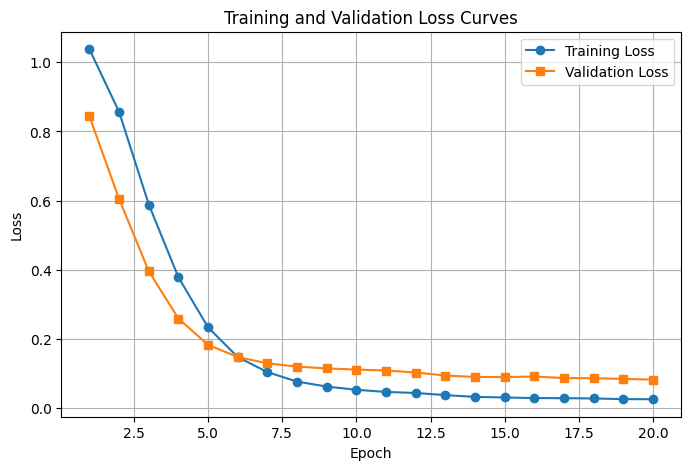

MAE:  0.08388753752045047


In [333]:
# site_directory = "../processed_ds/solar/"
# min_date = "2006-09-01"
# max_date = "2006-09-08 4:50"
# num_features = 10

site_directory = "../processed_ds/crypto-data/"
min_date = "2018-04-01"
max_date = "2018-06-15"
num_features = 5

# site_directory = "../processed_ds/stores_data/"
# min_date = "2013-01-16"
# max_date = "2015-07-31"
# num_features = 7

train_loader, val_loader, test_loader = load_all_sites_data(
    base_dir=site_directory,
    window_size=32, 
    horizon=16, 
    batch_size=16,
    min_date=min_date, 
    max_date=max_date
    )

# Define LSTM Model
model = LSTMModel(num_features=num_features, time_window=32, output_window=16, num_labels=1,  num_layers=2, hidden_size=8, dropout=0.5)

# Train the model
train_model(model, train_loader, val_loader ,num_epochs=20, lr=1e-4, wd=1e-5)

# Evaluate the model
mae = evaluate_model(model, test_loader)
print("MAE: ", mae)

Site: store-1 | Train: 593 | Validation: 148 | Test: 186
Site: store-10 | Train: 593 | Validation: 148 | Test: 186
Site: store-100 | Train: 476 | Validation: 118 | Test: 149
Site: store-1000 | Train: 476 | Validation: 118 | Test: 149
Site: store-1001 | Train: 593 | Validation: 148 | Test: 186
Site: store-1002 | Train: 593 | Validation: 148 | Test: 186
Site: store-1003 | Train: 593 | Validation: 148 | Test: 186
Site: store-1004 | Train: 476 | Validation: 118 | Test: 149
Site: store-1005 | Train: 593 | Validation: 148 | Test: 186
Site: store-1006 | Train: 593 | Validation: 148 | Test: 186
Site: store-1007 | Train: 593 | Validation: 148 | Test: 186
Site: store-1008 | Train: 593 | Validation: 148 | Test: 186
Site: store-1009 | Train: 476 | Validation: 118 | Test: 149
Site: store-101 | Train: 593 | Validation: 148 | Test: 186
Site: store-1010 | Train: 593 | Validation: 148 | Test: 186
Site: store-1011 | Train: 593 | Validation: 148 | Test: 186
Site: store-1012 | Train: 476 | Validation: 118

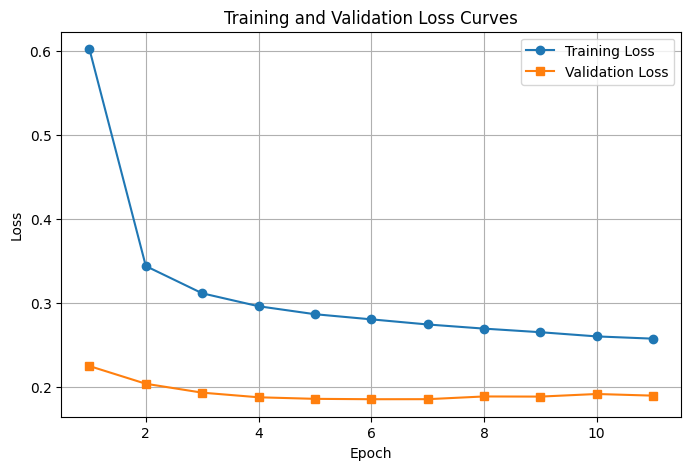

Test MAE: 0.3588
MAE:  0.35884066698637523


In [358]:
# site_directory = "../processed_ds/air_quality_cluster/"
# min_date = "2014-09-01"
# max_date = "2014-11-12 19:00"
# num_features = 11

# site_directory = "../processed_ds/solar/"
# min_date = "2006-09-01"
# max_date = "2006-09-08 4:50"
# num_features = 10


# site_directory = "../processed_ds/crypto-data/"
# min_date = "2018-04-01"
# max_date = "2018-06-15"
# num_features = 5

site_directory = "../processed_ds/stores_data/"
min_date = "2013-01-16"
max_date = "2015-07-31"
num_features = 7


balanced_train_loader, val_loaders, test_loaders = load_all_sites_balanced(
    base_dir=site_directory, 
    window_size=32, 
    horizon=2, 
    batch_size=32,
    min_date=min_date, 
    max_date=max_date
)
model = LSTMModel(num_features=num_features, time_window=32, output_window=2, num_labels=1,  num_layers=2, hidden_size=8, dropout=0.5)

train_model_balanced(model, balanced_train_loader, val_loaders, num_epochs=11, lr=1e-4, wd=1e-5)

# Evaluate the model
mae = evaluate_model_balanced(model, test_loaders)
print("MAE: ", mae)

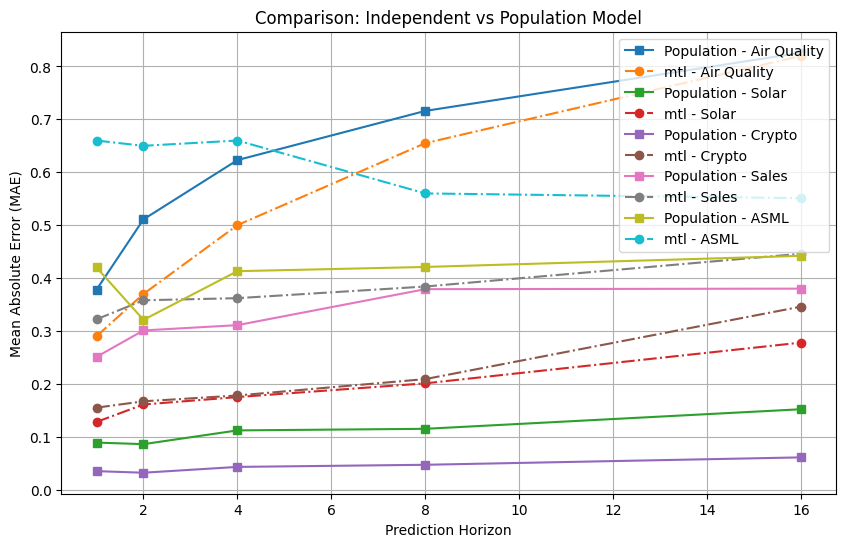

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Example Data
horizons = [1, 2, 4, 8, 16]  # Horizon steps
datasets = ['Air Quality', 'Solar', 'Crypto', 'Sales', 'ASML']

# Independent Model Results (MAE for each dataset)
independent_model_results = {
    'Air Quality': [0.516, 0.563, 0.629, 0.752, 0.912],
    'Solar': [0.227, 0.236, 0.242, 0.251, 0.314],
    'Crypto': [0.382, 0.470, 0.489, 0.538, 0.567],
    'Sales': [0.325, 0.394, 0.458, 0.491, 0.513],
    'ASML': [0.412, 0.592, 0.571, 0.603, 0.717],
}

# Population Model Results (MAE for each dataset)
population_model_results = {
    'Air Quality': [0.378, 0.511, 0.623, 0.716, 0.826],
    'Solar': [0.089, 0.086, 0.112, 0.115, 0.152],
    'Crypto': [0.035, 0.032, 0.043, 0.047, 0.061],
    'Sales': [0.251, 0.301, 0.311, 0.379, 0.380],
    'ASML': [0.42, 0.321, 0.413, 0.421, 0.442],
}

mtl_model_results = {
    'Air Quality': [0.29, 0.37, 0.50, 0.655, 0.82],
    'Solar': [0.128, 0.161, 0.175, 0.201, 0.278],
    'Crypto': [0.155, 0.167, 0.178, 0.209, 0.346],
    'Sales': [0.322, 0.358, 0.362, 0.384, 0.446],
    'ASML': [0.66, 0.65, 0.66, 0.56, 0.551],
}

# Plot Settings
plt.figure(figsize=(10, 6))

for dataset in datasets:
    # plt.plot(horizons, independent_model_results[dataset], marker='o', linestyle='-', label=f'Independent - {dataset}')
    plt.plot(horizons, population_model_results[dataset], marker='s', linestyle='-', label=f'Population - {dataset}')
    plt.plot(horizons, mtl_model_results[dataset], marker='o', linestyle='-.', label=f'mtl - {dataset}')

plt.xlabel("Prediction Horizon")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Comparison: Independent vs Population Model")
plt.legend()
plt.grid(True)

plt.show()